# Load data

We start by loading train & test data, and adding initial motion info:

In [1]:
import pandas as pd 
import os
import numpy as np
from data_cleaning import change_columns_types
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#immport necessary libraries and filter warnings
import warnings
# Create imputer, transformer objecs
from sklearn.compose import ColumnTransformer
import lightgbm
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from utility_db_25 import mark_columns, TrainML, build_catboost, optuna_call, test_ML, build_transformer, get_momentum_cols, create_momentum_index, get_final_features, get_motion_cols, motion_complexity_score, calc_tempo
from team_logos import graph_run_pass, get_logo_df, load_previous_year_passruns
warnings.filterwarnings("ignore")

In [2]:
root_dir = os.getcwd()

games_fname= os.path.join(root_dir, "data/games.csv")
plays_fname = os.path.join(root_dir,  "data/plays.csv")

train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

train colums:  457
test colums:  361


In [3]:
include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data=train_data[include_columns]
test_data = test_data[include_columns]

In [4]:
def get_momentum_cols(final_features):
    momentum_cols=[]
    for f in final_features:
        if 'shiftSinceLineset' in f:
            momentum_cols.append(f)
    return momentum_cols

In [5]:
def get_motion_cols(final_features):
    motion_cols=[]
    for f in final_features:
        if 'motionSinceLineset' in f:
            motion_cols.append(f)
    return motion_cols

In [6]:
motion_cols=get_motion_cols(train_data.columns)
momentum_cols=get_momentum_cols(train_data.columns)

### Explore positional motion/shift breakdown:

Below we see the number of records, by position, that have motion and shift data.

In [7]:
train_data[motion_cols].sum()

motionSinceLineset|C_1         0
motionSinceLineset|C_2         0
motionSinceLineset|FB_1      207
motionSinceLineset|G_1         0
motionSinceLineset|G_2         0
motionSinceLineset|G_3         0
motionSinceLineset|ILB_1       0
motionSinceLineset|QB_1        3
motionSinceLineset|RB_1     1189
motionSinceLineset|RB_2      105
motionSinceLineset|TE_1     1144
motionSinceLineset|TE_2      353
motionSinceLineset|TE_3       57
motionSinceLineset|T_1         0
motionSinceLineset|T_2         0
motionSinceLineset|T_3         0
motionSinceLineset|T_4         0
motionSinceLineset|WR_1      793
motionSinceLineset|WR_2      799
motionSinceLineset|WR_3      679
motionSinceLineset|WR_4        9
motionSinceLineset|WR_5        0
dtype: int64

In [8]:
train_data[momentum_cols].sum()

shiftSinceLineset|C_1         6
shiftSinceLineset|C_2         1
shiftSinceLineset|FB_1      149
shiftSinceLineset|G_1         5
shiftSinceLineset|G_2         8
shiftSinceLineset|G_3         6
shiftSinceLineset|ILB_1       0
shiftSinceLineset|QB_1        9
shiftSinceLineset|RB_1      461
shiftSinceLineset|RB_2       25
shiftSinceLineset|TE_1     1073
shiftSinceLineset|TE_2      369
shiftSinceLineset|TE_3       65
shiftSinceLineset|T_1        12
shiftSinceLineset|T_2         8
shiftSinceLineset|T_3         1
shiftSinceLineset|T_4         0
shiftSinceLineset|WR_1      423
shiftSinceLineset|WR_2      428
shiftSinceLineset|WR_3      318
shiftSinceLineset|WR_4        1
shiftSinceLineset|WR_5        0
dtype: int64

### Flag OL, see if they shifted, see ratio of pass/run

The OL never motions, and shifts rarely


In [9]:
# flag if any OL shifted
ol_cols = [x for x in momentum_cols if not set('BRE').intersection(x)]
train_data['ol_shift'] = train_data[ol_cols].sum(axis=1)
test_data['ol_shift'] = train_data[ol_cols].sum(axis=1)

In [10]:
train_data[train_data['ol_shift'].astype(bool)]['pass'].value_counts()

0    22
1     4
Name: pass, dtype: int64

## Examine positional shift impact on pass rate

We want to see the impact a position shifting has on pass rates below:

In [11]:
wr_shift_cols = [x for x in momentum_cols if 'WR' in x]
te_shift_cols = [x for x in momentum_cols if 'TE' in x]
rb_shift_cols = [x for x in momentum_cols if 'RB' in x]
fb_shift_cols = [x for x in momentum_cols if 'FB' in x]

train_data['wr_shift'] = train_data[wr_shift_cols].sum(axis=1)
train_data['te_shift'] = train_data[te_shift_cols].sum(axis=1)
train_data['rb_shift'] = train_data[rb_shift_cols].sum(axis=1)
train_data['fb_shift'] = train_data[fb_shift_cols].sum(axis=1)

In [12]:
[x for x in momentum_cols if 'RB' in x]

['shiftSinceLineset|RB_1', 'shiftSinceLineset|RB_2']

We see that RB's are the only position who, by shifting, increase pass rate:

In [13]:
len(train_data[train_data['rb_shift'].astype(bool)])

478

In [14]:
train_data['rb_shift'].sum()

486

In [15]:
wr_full_ratio = train_data[train_data['wr_shift'].astype(bool)]['pass'].sum()/len(train_data[train_data['wr_shift'].astype(bool)])
te_full_ratio = train_data[train_data['te_shift'].astype(bool)]['pass'].sum()/len(train_data[train_data['te_shift'].astype(bool)])
rb_full_ratio = train_data[train_data['rb_shift'].astype(bool)]['pass'].sum()/len(train_data[train_data['rb_shift'].astype(bool)])
fb_full_ratio = train_data[train_data['fb_shift'].astype(bool)]['pass'].sum()/len(train_data[train_data['fb_shift'].astype(bool)])
print(f'Any WR shifting implies a pass rate of {int(100*wr_full_ratio)}%')
print(f'Any RB shifting implies a pass rate of {int(100*rb_full_ratio)}%')
print(f'Any TE shifting implies a pass rate of {int(100*te_full_ratio)}%')
print(f'Any FB shifting implies a pass rate of {int(100*fb_full_ratio)}%')

Any WR shifting implies a pass rate of 45%
Any RB shifting implies a pass rate of 79%
Any TE shifting implies a pass rate of 31%
Any FB shifting implies a pass rate of 22%


#### WR shift/no-shift comparison

Notably, no real breakdown between *which* WR shifts, just that a WR shift happened.

Shifting slightly implies a run more often than not, while no shift implies a pass:

In [16]:
for i in range(1,4):
    wrs_df = train_data[train_data[f'shiftSinceLineset|WR_{i}'].astype(bool)]
    print(f'Pass ratio (wr{i} shift) is: {int(100*round(wrs_df["pass"].sum()/len(wrs_df),2))}%')

Pass ratio (wr1 shift) is: 48%
Pass ratio (wr2 shift) is: 43%
Pass ratio (wr3 shift) is: 49%


In [17]:
for i in range(1,4):
    nwrs_df = train_data[~train_data[f'shiftSinceLineset|WR_{i}'].astype(bool)]
    print(f'Pass ratio (no wr{i} shift) is: {int(100*round(nwrs_df["pass"].sum()/len(nwrs_df),2))}%')

Pass ratio (no wr1 shift) is: 61%
Pass ratio (no wr2 shift) is: 61%
Pass ratio (no wr3 shift) is: 61%


Note also, it's usually just one WR that moves:

In [18]:
train_data['wr_shift'].value_counts()

0    13498
1      961
2       82
3       15
Name: wr_shift, dtype: int64

#### TE shift

TE Shifting even more start, strongly implying a run:

In [19]:
for i in range(1,4):
    tes_df = train_data[train_data[f'shiftSinceLineset|TE_{i}'].astype(bool)]
    print(f'pass ratio (te{i} shift) is: {int(100*round(tes_df["pass"].sum()/len(tes_df),2))}%')

pass ratio (te1 shift) is: 35%
pass ratio (te2 shift) is: 28%
pass ratio (te3 shift) is: 31%


In [20]:
for i in range(1,4):
    ntes_df = train_data[~train_data[f'shiftSinceLineset|TE_{i}'].astype(bool)]
    print(f'pass ratio (no te{i} shift) is: {int(100*round(ntes_df["pass"].sum()/len(ntes_df),2))}%')

pass ratio (no te1 shift) is: 62%
pass ratio (no te2 shift) is: 61%
pass ratio (no te3 shift) is: 61%


#### RB Shift:

This is notable: while TE/WR shift *decrease* pass odds, RB shift *increases* them

In [21]:
for i in range(1,3):
    rbs_df = train_data[train_data[f'shiftSinceLineset|RB_{i}'].astype(bool)]
    print(f'pass ratio (rb{i} shift) is: {100*round(rbs_df["pass"].sum()/len(rbs_df),2)}%')

pass ratio (rb1 shift) is: 80.0%
pass ratio (rb2 shift) is: 64.0%


In [22]:
for i in range(1,3):
    nrbs_df = train_data[~train_data[f'shiftSinceLineset|RB_{i}'].astype(bool)]
    print(f'pass ratio (no rb{i} shift) is: {100*round(nrbs_df["pass"].sum()/len(nrbs_df),2)}%')

pass ratio (no rb1 shift) is: 60.0%
pass ratio (no rb2 shift) is: 60.0%


#### FB Shift 

FB shifts also depress pass rate:

In [23]:
fbs_df = train_data[train_data['shiftSinceLineset|FB_1'].astype(bool)]
fbs_rate = fbs_df['pass'].sum()/len(fbs_df)
print(f'pass ratio (fb shifted) is: {fbs_rate}')

fbns_df = train_data[~train_data['shiftSinceLineset|FB_1'].astype(bool)]
fbns_rate = fbns_df['pass'].sum()/len(fbns_df)
print(f'pass ratio (fb not shifted) is: {fbns_rate}')

pass ratio (fb shifted) is: 0.2214765100671141
pass ratio (fb not shifted) is: 0.6085930450475463


## Motion breakdown

We shifts; now we do motion, first with wr's:

In [24]:
for i in range(1,4):
    wrm_df = train_data[train_data[f'motionSinceLineset|WR_{i}'].astype(bool)]
    print(f'Pass rate (wr{i} motion) is: {int(100*round(wrm_df["pass"].sum()/len(wrm_df),2))}%')

Pass rate (wr1 motion) is: 79%
Pass rate (wr2 motion) is: 73%
Pass rate (wr3 motion) is: 75%


In [25]:
for i in range(1,4):
    nwrm_df = train_data[~train_data[f'motionSinceLineset|WR_{i}'].astype(bool)]
    print(f'Pass rate (no wr{i} motion) is: {int(100*round(nwrm_df["pass"].sum()/len(nwrm_df),2))}%')

Pass rate (no wr1 motion) is: 59%


Pass rate (no wr2 motion) is: 60%
Pass rate (no wr3 motion) is: 60%


#### Now TE's:

In [26]:
for i in range(1,4):
    tem_df = train_data[train_data[f'motionSinceLineset|TE_{i}'].astype(bool)]
    print(f'Pass rate (te{i} motion) is: {int(100*round(tem_df["pass"].sum()/len(tem_df),2))}%')

Pass rate (te1 motion) is: 74%
Pass rate (te2 motion) is: 70%
Pass rate (te3 motion) is: 72%


In [27]:
for i in range(1,4):
    ntem_df = train_data[~train_data[f'motionSinceLineset|TE_{i}'].astype(bool)]
    print(f'Pass rate (no te{i} motion) is: {int(100*round(ntem_df["pass"].sum()/len(ntem_df),2))}%')

Pass rate (no te1 motion) is: 59%
Pass rate (no te2 motion) is: 60%
Pass rate (no te3 motion) is: 60%


#### RB's:

In [28]:
for i in range(1,3):
    rbm_df = train_data[train_data[f'motionSinceLineset|RB_{i}'].astype(bool)]
    print(f'Pass rate (rb{i} motion) is: {int(100*round(rbm_df["pass"].sum()/len(rbm_df),2))}%')

Pass rate (rb1 motion) is: 74%
Pass rate (rb2 motion) is: 55%


In [29]:
for i in range(1,3):
    nrbm_df = train_data[~train_data[f'motionSinceLineset|RB_{i}'].astype(bool)]
    print(f'Pass rate (no rb{i} motion) is: {int(100*round(nrbm_df["pass"].sum()/len(nrbm_df),2))}%')

Pass rate (no rb1 motion) is: 59%
Pass rate (no rb2 motion) is: 61%


And finally, FB's:

In [30]:
fbm_df = train_data[train_data['motionSinceLineset|FB_1'].astype(bool)]
fbm_rate = fbm_df['pass'].sum()/len(fbm_df)
print(f'pass ratio (fb motion) is: {fbm_rate}')

fbm_df = train_data[~train_data['motionSinceLineset|FB_1'].astype(bool)]
fbm_rate = fbm_df['pass'].sum()/len(fbm_df)
print(f'pass ratio (no fb motion) is: {fbm_rate}')

pass ratio (fb motion) is: 0.6666666666666666
pass ratio (no fb motion) is: 0.6037354519478709


# Create new shift and motion metrics

### Explore how motion-momentum affects pass rates

We can see why motion-momentum is such a strong metric below. 

In short, if more players are motioning, that implies a pass, while more shifting implies a run.

If both are equal (potentially implying neither a motion nor a shift), we get 60%, which is nearly the league base pass rate.

In [31]:
# calc motion-momentum
train_data['presnap_motion_complexity']=train_data[motion_cols].sum(axis=1).fillna(0).astype(float)
train_data['presnap_momentum']=train_data[momentum_cols].sum(axis=1).fillna(0).astype(float)
train_data['motion-momentum']= (train_data['presnap_motion_complexity']-train_data['presnap_momentum']).astype(float)

# calc relative splits
less_motion = int((train_data[train_data['motion-momentum'] <0 ]['pass'].sum() / len(train_data[train_data['motion-momentum'] <0 ])).round(2)*100)
less_shift = int((train_data[train_data['motion-momentum'] >0 ]['pass'].sum() / len(train_data[train_data['motion-momentum'] >0 ])).round(2)*100)
both_equal = int((train_data[train_data['motion-momentum'] ==0 ]['pass'].sum() / len(train_data[train_data['motion-momentum'] ==0 ])).round(2)*100)
print(f'Pass rate when more players shift than motion is: {less_motion}%')
print(f'Pass rate when more players motion than shift is: {less_shift}%')
print(f'Pass rate when players shift and motion equally is: {both_equal}%')

Pass rate when more players shift than motion is: 37%
Pass rate when more players motion than shift is: 74%
Pass rate when players shift and motion equally is: 60%


### Create new shift, motion metrics

Essentially, our best results come from excluding RB2 and OL data due to small sample size, as well as WR 4/5

In [32]:
motioncols = [x for x in train_data.columns if 'motionSinceLineset|' in x and set('BRE').intersection(x) and not set('IQ45').intersection(x) and 'RB_2' not in x]#+['shiftSinceLineset|RB_1']
shift_cols = [x for x in train_data.columns if 'shiftSinceLineset|' in x and set('BRE').intersection(x) and not set('IQ45').intersection(x) and 'RB_2' not in x and 'RB_1' not in x]+['shiftSinceLineset|RB_1']#+['ol_shift'] #

In [33]:
motioncols

['motionSinceLineset|FB_1',
 'motionSinceLineset|RB_1',
 'motionSinceLineset|TE_1',
 'motionSinceLineset|TE_2',
 'motionSinceLineset|TE_3',
 'motionSinceLineset|WR_1',
 'motionSinceLineset|WR_2',
 'motionSinceLineset|WR_3']

In [34]:
shift_cols

['shiftSinceLineset|FB_1',
 'shiftSinceLineset|TE_1',
 'shiftSinceLineset|TE_2',
 'shiftSinceLineset|TE_3',
 'shiftSinceLineset|WR_1',
 'shiftSinceLineset|WR_2',
 'shiftSinceLineset|WR_3',
 'shiftSinceLineset|RB_1']

### Compare impact of players shifting with and without RB1

If we exclude RB1's from our shift data, we gain little from knowing *how many* players shifted.

 With them included, however, we see a real jump in pass rate going from one to two players shifting.

In [35]:
shift_2_plus = train_data[train_data[shift_cols].sum(axis=1) >= 2]['pass'].sum()/len(train_data[train_data[shift_cols].sum(axis=1) >= 2]['pass'])
shift_1 = train_data[train_data[shift_cols].sum(axis=1) == 1]['pass'].sum()/len(train_data[train_data[shift_cols].sum(axis=1) == 1]['pass'])
shift_0 = train_data[train_data[shift_cols].sum(axis=1) == 0]['pass'].sum()/len(train_data[train_data[shift_cols].sum(axis=1) == 0]['pass'])
print(f'Pass rate if two players shifted (rb1 included): {round(shift_2_plus*100,1)}%')
print(f'Pass rate if one player shifted (rb1 included): {round(shift_1*100,1)}%')
print(f'Pass rate if no players shifted (rb1 included): {round(shift_0*100,1)}%')

Pass rate if two players shifted (rb1 included): 54.3%
Pass rate if one player shifted (rb1 included): 37.9%
Pass rate if no players shifted (rb1 included): 64.8%


Compare with RB1 excluded:

In [36]:
shift_2_plus_no_rb = train_data[train_data[shift_cols[:-1]].sum(axis=1) >= 2]['pass'].sum()/len(train_data[train_data[shift_cols[:-1]].sum(axis=1) >= 2]['pass'])
shift_1_no_rb  = train_data[train_data[shift_cols[:-1]].sum(axis=1) == 1]['pass'].sum()/len(train_data[train_data[shift_cols[:-1]].sum(axis=1) == 1]['pass'])
shift_0_no_rb  = train_data[train_data[shift_cols[:-1]].sum(axis=1) == 0]['pass'].sum()/len(train_data[train_data[shift_cols[:-1]].sum(axis=1) == 0]['pass'])
print(f'Pass rate if two players shifted (rb1 excluded): {round(shift_2_plus_no_rb*100,1)}%')
print(f'Pass rate if one player shifted (rb1 excluded): {round(shift_1_no_rb*100,1)}%')
print(f'Pass rate if no players shifted (rb1 excluded): {round(shift_0_no_rb*100,1)}%')

Pass rate if two players shifted (rb1 excluded): 44.9%
Pass rate if one player shifted (rb1 excluded): 35.0%
Pass rate if no players shifted (rb1 excluded): 65.2%


### Codify motion, shift features

We now codify our motion + shift features:

In [37]:
train_data['movement_motion'] = train_data[motioncols].sum(axis=1).astype(float)
train_data['movement_shift'] = train_data[shift_cols].sum(axis=1).astype(float)
train_data['movement_delta'] = train_data['movement_motion']-train_data['movement_shift']
test_data['movement_motion'] = test_data[motioncols].sum(axis=1).astype(float)
test_data['movement_shift'] = test_data[shift_cols].sum(axis=1).astype(float)
test_data['movement_delta'] = test_data['movement_motion']-train_data['movement_shift']

In [38]:
train_data = pd.concat([train_data.iloc[:,:-10],train_data[['movement_motion','movement_shift','movement_delta']]],axis=1)

# Test impact on model

We see a decent (~.5%) boost from breaking out motion/shift data, and including only positions w/large samples

In [39]:
def calc_ipa (data):
    ipa = (.7* data['a|max|QB_1'] + .2*data['run_val'] + \
 data['receiverAlignment_2x2'] + data['motionSinceLineset|RB_2'] + .1*data['x_standard|std|WR_1']\
    + .1*data['s|max|G_2'] + data['surface_fieldturf'] + .05*data['time_remaining']).values
    return ipa

train_data['ipa'] = calc_ipa(train_data)
test_data['ipa'] = calc_ipa(test_data)

In [40]:
df_plays = pd.read_csv(plays_fname)
calc_tempo(df_plays)
df_plays[['gameId','playId','tempo']].head(2)

,gameId,playId,tempo
0,2022102302,2655,0.355556
1,2022091809,3698,0.444444


In [41]:
train_data = train_data.merge(df_plays[['gameId','playId','tempo']],how='left',on=['gameId','playId'])
test_data = test_data.merge(df_plays[['gameId','playId','tempo']],how='left',on=['gameId','playId'])

In [42]:
train_data=create_momentum_index(train_data, momentum_cols)
test_data=create_momentum_index(test_data, momentum_cols)

train_data=motion_complexity_score(train_data, motion_cols)
test_data=motion_complexity_score(test_data, motion_cols)

In [43]:
for col in train_data.columns: 
    if col != 'pass':
        if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
            train_data.drop(columns=col, inplace=True)
        elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
            print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
        else: 
            continue

pass_rush_ratio 2.84 % missing
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing


In [44]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [45]:
SEED=42
n_splits=5

In [46]:
final_features=['xpass_situational',  'QB_RB1_offset','off_xpass','n_offense_backfield',#'receiverAlignment_3x2' #'QBdffy_RB', 'QBdff_T', 
        #'movement_delta',#'motion-momentum',    
        'movement_motion',
        'movement_shift',
        'ipa','tempo',
        'neg_Formations', 'mean_pairwise_dist']
numeric_columns, cat_columns = mark_columns(df=train_data,features=final_features, nc=None,cc = None)
final_numeric_columns, final_cat_columns = mark_columns(df=train_data,features=final_features, nc=numeric_columns,cc = cat_columns)

In [47]:
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [48]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

X=train_data[final_features]
y=train_data['pass']

In [49]:
transformer_impute = build_transformer(imputer,numeric_columns,kind='imputer')
transformer_scale = build_transformer(imputer,numeric_columns,kind='scaler')

In [50]:
# import relevant play/week info
plays_df = pd.read_csv(plays_fname)[['gameId','playId']]
games_df = pd.read_csv(games_fname)[['gameId','week']]
id_week = plays_df.merge(games_df,how='left')

# mark train data with week info
train_marked = train_data.merge(id_week,how='left')

In [51]:
# truncate to week 2 on, get length of week 8
train_trunc = train_marked.loc[train_marked[(train_marked['week'] >=2)].index]
w8_len = len(train_trunc[train_trunc['week'] == 8].index)

# -1 is train, 1 is holdout, per predefinedsplit parlance
ind_train = [-1]*(len(train_trunc)-w8_len)
ind_val = [1]*w8_len

# sanity check our split
len(ind_train) == len(train_trunc[train_trunc['week'] < 8])
len(ind_train+ind_val) == len(train_trunc)

True

In [52]:
cv_ind = ind_train+ind_val
ps = PredefinedSplit(test_fold=cv_ind)

In [53]:
X = train_trunc[final_features]
y = train_trunc['pass']

In [71]:
train_trunc[final_features[-4:]+['pass']].corr()

,ipa,tempo,neg_Formations,mean_pairwise_dist,pass
ipa,1.000000,-0.010421,0.089688,-0.105590,-0.009087
tempo,-0.010421,1.000000,-0.009369,-0.001305,-0.006410
neg_Formations,0.089688,-0.009369,1.000000,-0.391906,-0.413459
mean_pairwise_dist,-0.105590,-0.001305,-0.391906,1.000000,0.317313
pass,-0.009087,-0.006410,-0.413459,0.317313,1.000000


In [54]:
# Initialize an empty dictionary to store the best hyperparameters and their values
best_hyperparameters = {}
best_values = {}
 
# Initialize the LightGBM classifier
lgb_classifier = lightgbm.LGBMClassifier(force_col_wise=True, deterministic=True, random_state=42)

# Define a range of values for the hyperparameters to search through
param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    'num_leaves': [25, 30, 40, 50],
    'learning_rate': [ 0.1,.15],
    'max_depth': [4,5,6,7],
    'n_estimators': [75, 100],
    #'is_unbalance': [True],
    'random_state': [42],
    "deterministic": [True],
    'verbose': [-1]
}


#Initialize GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=ps)
 

# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X,y)
 
# Get the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())

'''
for i in range(5):
    key = 'split' + str(i) + '_test_score'
    print(np.mean(grid_search.cv_results_[key])
'''

best_params


{'boosting_type': 'gbdt',
 'deterministic': True,
 'learning_rate': 0.15,
 'max_depth': 5,
 'n_estimators': 75,
 'num_leaves': 25,
 'random_state': 42,
 'verbose': -1}

In [55]:
best_params = {'boosting_type': 'dart',
 'max_depth': 4,
 'deterministic': True,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'num_leaves': 50,
 'random_state': 42}

In [56]:
grid_search.best_score_

0.7887005649717514

In [57]:
# Train a LightGBM model with the best hyperparameters
best_model = lightgbm.LGBMClassifier(**best_params)
best_model.fit(X,y)

LGBMClassifier(boosting_type='dart', deterministic=True, max_depth=4,
               num_leaves=50, random_state=42)

In [58]:
y_pred = best_model.predict(test_data[final_features])
y_test = test_data['pass']

In [59]:
accuracy_score(y_test, y_pred)

0.8326797385620915

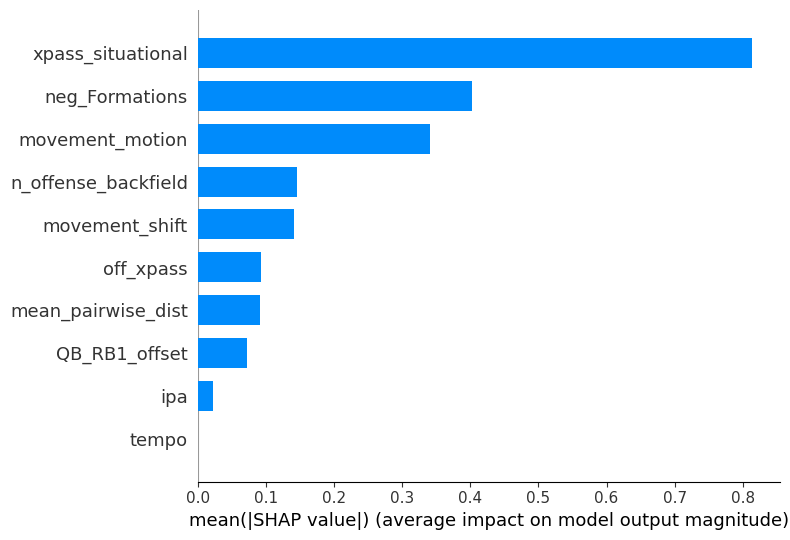

In [64]:
import shap 
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
feature_names = final_features


lgbm_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(lgbm_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)


AUC --> 0.8218185040765685
Accuracy --> 0.8326797385620915


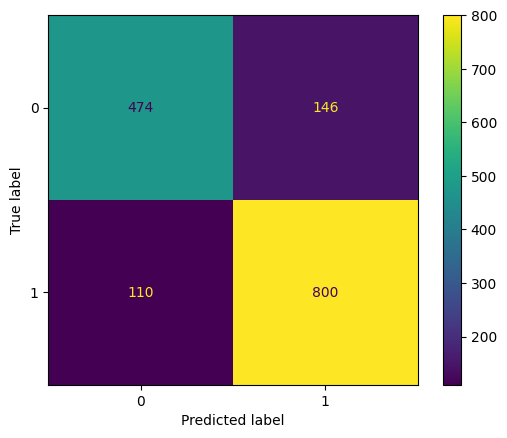

In [65]:
test_ML(test_data, best_model,final_features,transformer_impute,transformer_scale)